# Temperatures & Adaptation
For setting the temperatures we will expand on the [Quickstart] example:

In [1]:
from IPython.display import Image, display

import matplotlib.pyplot as pl
from matplotlib.ticker import MaxNLocator

import numpy as np
import reddemcee

np.random.seed(1234)

### Definitions
We will use the same definitions as in Quickstart:

In [2]:
ndim_ = 2  # n dimensions
r_ = 2.  # radius
w_ = 0.1  # width
hard_limit = 6  # hard search boundary

limits_ = [-hard_limit,  hard_limit]
c1_ = np.zeros(ndim_)
c1_[0] = -3.5
c2_ = np.zeros(ndim_)
c2_[0] = 3.5
const_ = np.log(1. / np.sqrt(2. * np.pi * w_**2))

In [3]:
def logcirc(theta, c):
    # log-likelihood of a single shell
    d = np.sqrt(np.sum((theta - c)**2, axis=-1))  # |theta - c|
    return const_ - (d - r_)**2 / (2. * w_**2)


def loglike(theta):
    # log-likelihood of two shells
    return np.logaddexp(logcirc(theta, c1_), logcirc(theta, c2_))


def logprior(theta):
    # prior for our parameters
    lp = 0.
    for i in range(ndim_):
        if  theta[i] <= limits_[0] or limits_[1] <= theta[i]:
            return -np.inf
    return lp

In [4]:
def display_samples(sampler, temp=0):
    nd = sampler.ndim
    fig, axes = pl.subplots(1, nd, figsize=(8, 2*nd))
    
    samples = sampler.get_chains(flat=True)
    
    for i in range(len(axes)):
        axes[i].hist(samples[temp][:, i], 100, histtype="step", lw=1)
        axes[i].set_xlabel(fr"$\theta_{i}$")
        axes[i].set_ylabel(fr"$p(\theta_{i})$")
    pl.gca().set_yticks([])
    fig.suptitle('Samples')
    
def display_chains(sampler, dens=False, temp=0):
    nd = sampler.ndim
    fig, axes = pl.subplots(nd, 1, sharex=True, figsize=(8, nd*3))
    samples = sampler.get_func('get_chain', kwargs={'flat':False})
    for i in range(len(axes)):
        if dens:
             axes[i].plot(samples[temp][:, :, i], marker='o', alpha=0.75, lw=0)
        else:
             axes[i].plot(samples[temp][:, :, i], alpha=0.75, lw=1)
        
        axes[i].yaxis.set_major_locator(MaxNLocator(5))
        axes[i].set_ylabel(fr"$p(\theta_{i})$")
        
    fig.suptitle('Chains')
    fig.supxlabel('Step')

### Setup
We will set 10 temperatures and a bit of a longer chain for this example:

In [5]:
ntemps, nwalkers, nsweeps, nsteps = [10, 100, 300, 2]
p0 = list(np.random.uniform(limits_[0], limits_[1], [ntemps, nwalkers, ndim_]))

## Temperatures
You can:
- set ntemps=int, to the number of temperatures you want to use.
- set betas=array, to the be the initial temperature ladder.

If betas is not specified, it default to a geometrically spaced ladder, defined in (Vousden et al).

First we will take a look at a 'standard' Parallel tempering, without adaptation:

In [6]:
sampler = reddemcee.PTSampler(nwalkers, ndim_, loglike, logprior,
                              ntemps=ntemps,
                              adaptative=False)
    
silent = sampler.run_mcmc(p0, nsweeps, nsteps, progress=True)

100%|████████████| 600/600 [00:09<00:00, 65.28it/s]


We take a quick look at what the samples look like for the cold chain:

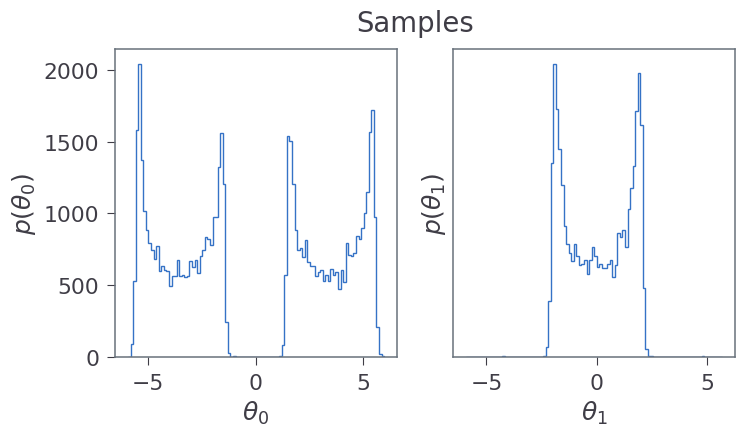

In [7]:
display_samples(sampler)

We would expect to see flatter distributions in hotter chains:

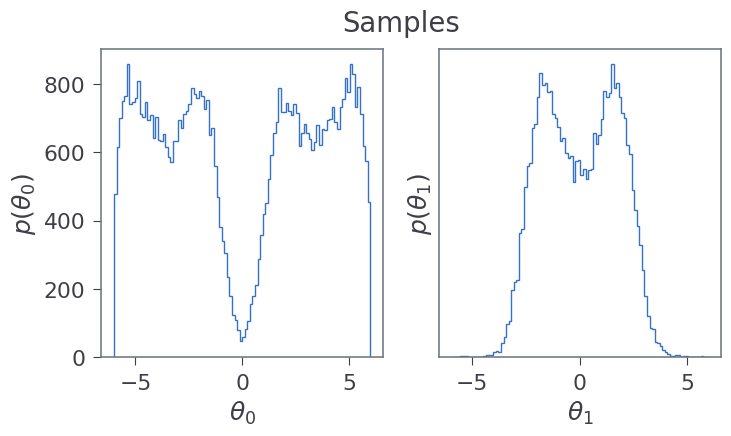

In [8]:
display_samples(sampler, temp=2)

## Adaptation

We take a look at the temperature adaptation using different configurations, using a linearly spaced initial ladder, to better visualise temperature changes.

- set adaptative=bool, to turn on/off the Adaptation
- config_adaptation_halflife=float, adaptation decay halflife
- config_adaptation_rate=float, adaptation rate (more like inverse coefficient)
- config_adaptation_decay=int[0,1,2], for different adaptation approaches

To visualize changes we define a plot function:

In [9]:
def plot_betas_ratios(sampler, setup):
    bh = sampler.betas_history
    rh = sampler.ratios_history

    fig, axes = pl.subplots(2, 1, figsize=(9, 5), sharex=True)

    bh1 = bh.reshape((setup[2], setup[0]))
    rh1 = rh.reshape((setup[2], setup[0]-1))

    for i in range(setup[0]-2):
            bh_sel = bh1[:, i]
            b = 1/np.array(bh_sel)
            axes[0].plot(np.arange(setup[2])*setup[3], b)
            axes[0].set_xscale('log')
            axes[0].set_yscale('log')


    for i in np.arange(setup[0]-1):
        r = rh1[:, i]
        axes[1].plot(np.arange(setup[2])*setup[3], r, alpha=0.5)

    if True:
        axes[1].set_xlabel("N Step")
        axes[0].set_ylabel(r"$\beta^{-1}$")
        axes[1].set_ylabel(r"$a_{frac}$")

    pl.tight_layout()

In [10]:
my_betas = np.linspace(1, 0, ntemps)
setup = ntemps, nwalkers, nsweeps, nsteps

In [11]:
sampler = reddemcee.PTSampler(nwalkers, ndim_, loglike, logprior,
                              ntemps=ntemps,
                              betas=my_betas,
                              adaptative=True,
                              config_adaptation_halflife=600,
                              config_adaptation_rate=0.3,
                              config_adaptation_decay=0)
    
silent = sampler.run_mcmc(p0, nsweeps, nsteps, progress=True)

100%|████████████| 600/600 [00:09<00:00, 64.89it/s]


We can see how the temperatures vary over time, until their acceptance fractions converge to the same value.

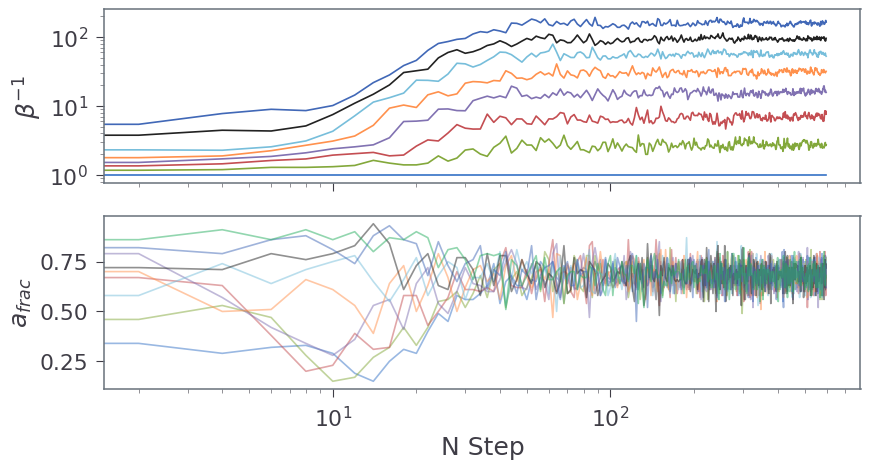

In [12]:
plot_betas_ratios(sampler, setup)

I highly encourage playing with the three config_adaptation parameters in this example to check how they behave.